In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
def connect_graph(G,v, **kwargs):
    """connects a graph. All edges will be length 1 between connected component
    graph and point locaitons (for triangle inequality) as input
    
    returns a graph 
    """
    adjmat = nx.to_numpy_matrix(G)
    concomp = nx.algorithms.components.connected_components(G)
    choices = []
    for comp in concomp:
        choices.append(np.random.choice(list(comp), 1, replace = False)[0])
    choices = np.array(choices)
    import itertools
    indecies = np.array(list(itertools.product(choices, choices)))
    setter = []
    for index in indecies:
        if index[0] == index[1]:
            setter.append(False)
        else:
            setter.append(True)
    indecies = indecies[setter]
    for index in indecies:
        adjmat[index[0], index[1]] = np.linalg.norm(v[index[0]] - v[index[1]])
        adjmat[index[1], index[0]] = np.linalg.norm(v[index[0]] - v[index[1]])
        
    return nx.from_numpy_matrix(adjmat)

In [3]:
def check_triangle(G, **kwargs):
    spaths = nx.algorithms.shortest_paths.generic.shortest_path(G)
    nnodes = len(G._node)
    for i, row in enumerate(nx.to_numpy_array(G)):
        for j, w in enumerate(row):
            if w != 0:
                if len(spaths[i][j]) != 2:
                    return False
    return True

In [4]:
def connect_2clusters(graphs, vs, maxconnections = 1, verbosity = 0, **kwargs):
    """
    array like of of graphs
    array like of points in each graph
    maxconnections is how many connections between clusters
    """
    G1, G2 = graphs
    v1, v2 = vs
    a, b = nx.to_numpy_array(G1), nx.to_numpy_array(G2)
    anew = np.concatenate((a, np.zeros((a.shape[0], b.shape[0]), )),axis = 1)
    bnew = np.concatenate((np.zeros((b.shape[0], a.shape[0]),), b),axis = 1)
    out = np.concatenate((anew,bnew),axis = 0)
    concomplist = list(nx.algorithms.components.connected_components(nx.from_numpy_array(out)))
    if len(concomplist)!= 2:
        raise ValueError('trying to merge more than two graphs')
    ncon = np.random.randint(low = 1, high = maxconnections+1)
    choices_from_first = np.random.choice(list(concomplist[0]), ncon,)
    choices_from_second = np.random.choice(list(concomplist[1]), ncon) 
    for inds in zip(choices_from_first, choices_from_second):
        dist = np.linalg.norm(v1[inds[0]] - v2[inds[1]- len(concomplist[0])]) #to get the indexing correct for the points
        out[inds[0], inds[1]] = dist
        out[inds[1], inds[0]] = dist
    G = nx.from_numpy_array(out)
    if not check_triangle(G, **kwargs):
        raise ValueError('not satisfy triangle')
    if not nx.algorithms.components.connected.is_connected(G):
        raise ValueError('not connected')
    v = np.concatenate((v1, v2)) 
    if verbosity>1:
        print('generated ', ncon, ' connections between clusters')
    return G, v

In [5]:
def generate_cluster(nnodes, p, yrange=(0,1), xrange = (0,1), **kwargs):
    """returns a connected graph and location of points in space for generating a clustered graph
    
    nnodes - how many nodes in cluster
    p - probability of generating an edge between nodes
    """
    n = nnodes
    G = nx.fast_gnp_random_graph(n, p,)
    adjmat = nx.to_numpy_matrix(G)

    #generate random n random points:
    v = np.random.rand(n, 2)
    v[:,0] = (v[:,0] )*(xrange[1] - xrange[0]) + xrange[0]
    v[:,1] = (v[:,1] )*(yrange[1] - yrange[0]) + yrange[0]
    
    #check if connected
    G = connect_graph(G, v, **kwargs)
    adjmat = nx.to_numpy_matrix(G)
    
    
    tadjmat = adjmat.copy()
    for i, row in enumerate(adjmat):
        newrow = np.array([np.linalg.norm(v[i] - v[j]) for j in range(n)])*np.array(row)
        tadjmat[i] = newrow

    adjmat = tadjmat
    del tadjmat
    adjmat
    Gp = nx.from_numpy_matrix(adjmat)
    return Gp, v

In [6]:
G1, v1 = generate_cluster(10, .1,xrange = (5,10), yrange= (-1,1)) # one paramter is how dense each cluster is. we may do better if they are dense
G2, v2 = generate_cluster(20, .5,xrange = (0,2), yrange= (9,15))

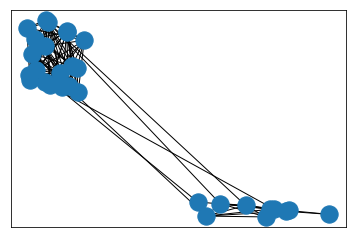

In [7]:
G, v = connect_2clusters((G1, G2), (v1, v2),maxconnections=5,)
pos = dict()
for i, vi in enumerate(v):
    pos.update({i:vi})
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

## I don't really think it is fruitful to right a complete function, but it can be done easy

In [511]:
def generate_clustered_graph(k, nnodes = 10,**kwargs):
    """
    k - how many clusters
    nnodes - int . how many nodes total
    """
    nodes_per_cluster = []
    
    return G, v

In [566]:
k, nnodes = 5, 15
nper = []
for i, worker in enumerate(np.sort(np.random.choice(np.linspace(1,nnodes,nnodes), k-1, replace = False))):
    if i == 0:
        last = 0
    nper.append(int(worker - last))
    last = worker
nper.append(int(nnodes - last))
nper #how many nodes per cluster


[3, 3, 1, 4, 4]

## Now lets generate a real graph of size 100 and 5 clusters

In [25]:
G1, v1 = generate_cluster(20, .1,xrange = (5,10), yrange= (-1,1)) 
G2, v2 = generate_cluster(20, .1,xrange = (0,2), yrange= (9,15))
G3, v3 = generate_cluster(20, .1,xrange = (-17,-16), yrange= (-12,-11))
G4, v4 = generate_cluster(20, .1,xrange = (32,45), yrange= (9,15))
G5, v5 = generate_cluster(20, .1,xrange = (10,18), yrange= (16,21))

In [26]:
G, v = connect_2clusters((G1, G2), (v1, v2), maxconnections = 5)

for gi, vi in zip([G3, G4, G5], [v3, v4, v5]):
    G, v = connect_2clusters((G, gi), (v, vi), maxconnections = 5)

dropoff nodes:  [16 21 51 73 93]


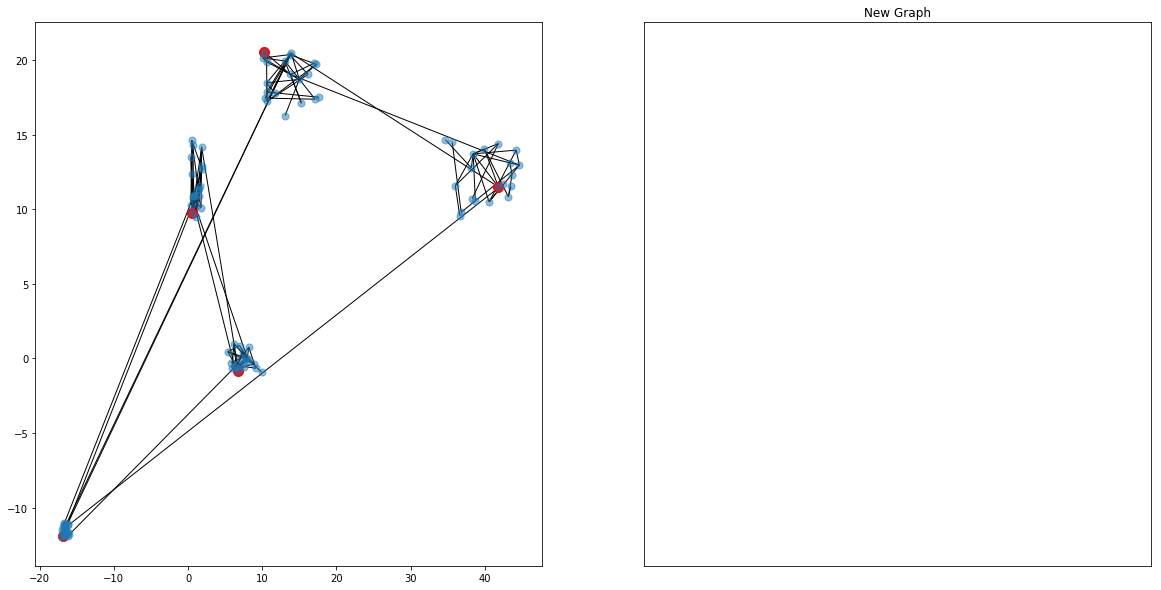

In [27]:
fig, axs = plt.subplots(ncols = 2, figsize = (20,10))

ax = axs[0]

pos = dict()
for i, vi in enumerate(v):
    pos.update({i:vi})
nx.draw_networkx_nodes(G, pos, ax = ax, alpha = .5, node_size = 50)
nx.draw_networkx_edges(G, pos, ax = ax)

#generate drop off points (one in each cluster)
dropoffs = np.array([np.random.randint(20) for i in range(5)]) + np.array([0,20,40,60,80])#20 points per cluster
dropoff_pts = v[dropoffs]
ax.scatter(dropoff_pts[:,0],dropoff_pts[:,1], color = 'red', s = 100)
print('dropoff nodes: ', dropoffs)
axs[1].set_title('New Graph')
s = dropoffs[0]
d1, d2, d3, d4 = np.array(dropoffs)[1:]
dropoffnodes = dropoffs

In [28]:
nx.readwrite.gpickle.write_gpickle(G, './graphstore/tempG.pkl')

In [56]:
nodes = [int(x) for x in np.linspace(0, 99, 100)]
nhomes = 25
homes = np.random.choice(nodes, nhomes, replace = False)

array([58, 55, 71, 65, 54, 67, 42, 45, 84, 91, 29, 11, 92, 47,  3, 53, 39,
       76, 83, 68, 26, 64, 44, 57, 50])

In [80]:
dropoffs = np.concatenate((np.array([homes[0]]),dropoffs))

In [81]:
import pickle
with open('./graphstore/dropoffnodes.pkl', 'wb') as f:
    pickle.dump(dropoffs, f)
    
with open('./graphstore/homes.pkl', 'wb') as f:
    pickle.dump(homes, f)
    
with open('./graphstore/spatiallocations.pkl', 'wb') as f:
    pickle.dump(v, f)

# aaaand done

next is generating new graph

In [159]:
G = nx.readwrite.gpickle.read_gpickle('./graphstore/tempG.pkl')
import pickle
with open('./graphstore/dropoffnodes.pkl', 'rb') as f:
    dropoffnodes = pickle.load(f)
with open('./graphstore/spatiallocations.pkl', 'rb') as f:
    v = pickle.load(f)
with open('./graphstore/homes.pkl', 'rb') as f:
    homes = pickle.load(f)

In [171]:
pos[nodemapper[0]]

array([-16.66693435, -11.55174289])

dropoff nodes:  [58 16 21 51 73 93]


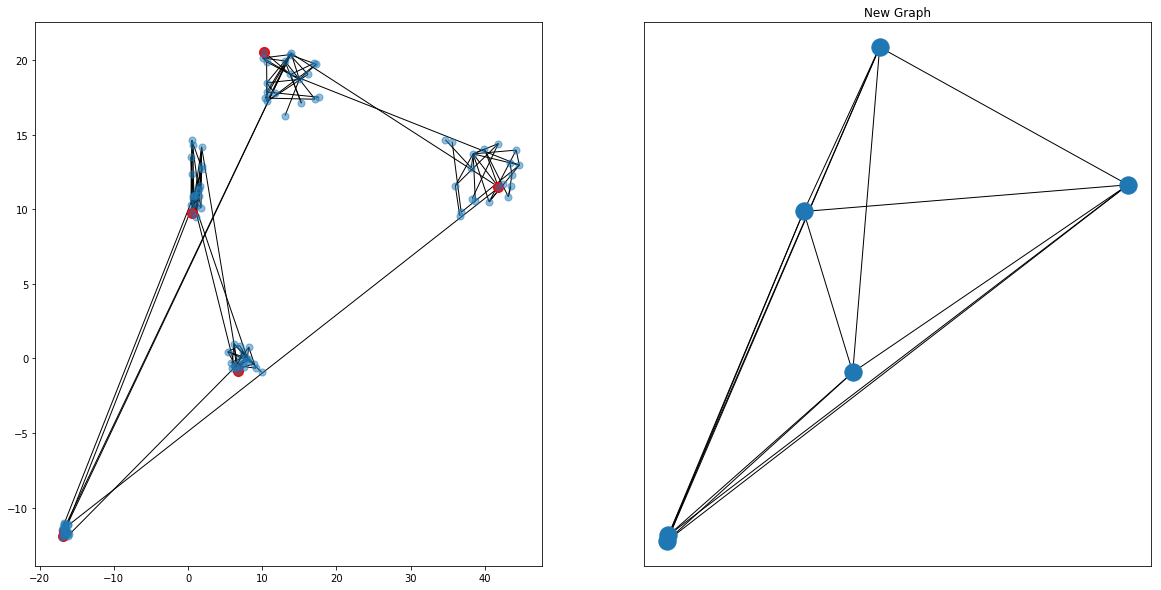

In [174]:
fig, axs = plt.subplots(ncols = 2, figsize = (20,10))

ax = axs[0]

pos = dict()
for i, vi in enumerate(v):
    pos.update({i:vi})
nx.draw_networkx_nodes(G, pos, ax = ax, alpha = .5, node_size = 50)
nx.draw_networkx_edges(G, pos, ax = ax)

dropoff_pts = v[dropoffnodes]
ax.scatter(dropoff_pts[:,0],dropoff_pts[:,1], color = 'red', s = 100)
print('dropoff nodes: ', dropoffnodes)
title = axs[1].set_title('New Graph')


newG, nodemapper, edge_to_path_mapper = create_new_graph(G, dropoffnodes)

posnew = dict()
for key in nodemapper:
    posnew.update({key:pos[nodemapper[key]]})

nx.draw_networkx_nodes(newG, posnew, ax = axs[1], alpha = 1, node_size = 300)
nx.draw_networkx_edges(newG, posnew, ax = axs[1])

In [168]:
print(dropoffs)
print(dropoffnodes)

[58 16 21 51 73 93]
[58 16 21 51 73 93]


In [222]:
def create_new_graph(G, dropoffnodes):
    """
    returns 
    newG - fully connected graph with edge weights given by the shortest path between drop off points
    nodemapper - dict, maps nodes in newG to nodes in G
    edge_to_path_mapper - dict, maps edges in newG to paths in G
    """
    adjarr = nx.to_numpy_array(G)
    spaths = nx.shortest_path(G,)
    ndropoffs = len(dropoffnodes)
    newmat = np.zeros((ndropoffs, ndropoffs))
    for i in range(ndropoffs):
        for j in range(i, ndropoffs):
            if i == j:
                newmat[i,i] = 0
            else:
                node1, node2 = dropoffnodes[i], dropoffnodes[j]
                path = spaths[node1][node2]
                pathlen = 0
                for k, node in enumerate(path):
                    if k == 0:
                        continue
                    pathlen+=adjarr[node, path[k-1]]
                newmat[i, j] = pathlen
                newmat[j, i] = pathlen
            
    newG = nx.from_numpy_array(newmat)
    newnodes = list(newG.nodes)
    nodemapper = dict()
    for l, node in enumerate(newnodes):
        nodemapper.update({node:dropoffnodes[l]})

    edge_to_path_mapper = dict()
    newedges = list(newG.edges)
    for edge in newedges:
        edge_to_path_mapper.update({edge:spaths[nodemapper[edge[0]]][nodemapper[edge[1]]]})
        edge_to_path_mapper.update({tuple(list(edge)[::-1]):spaths[nodemapper[edge[1]]][nodemapper[edge[0]]]})
    return newG, nodemapper, edge_to_path_mapper

In [223]:
newG, nodemapper, edge_to_path_mapper = create_new_graph(G, dropoffnodes)

In [239]:
def find_path_in_new_graph(newG,n=5):
    """ this will be where we implement tsp, but for now, it just generates n(=5) valid cycles and takes the minimum
    
    path visits every node and starts and finishes at node 0
    """
    visited = set({0})
    
    finalpathlen = np.inf
    for trial in range(n):
    
        nnodes = len(newG.nodes)
        poss = [int(x) for x in np.linspace(1,nnodes-1, nnodes-1)]
        order = np.random.choice(poss, nnodes-1, replace = False)
        order = np.concatenate((np.array([0]), order, np.array([0])),)
        adjmat = nx.to_numpy_array(newG)
        pathlen = 0
        for k, node in enumerate(order):
            if k == 0:
                continue
            pathlen+=adjmat[node, order[k-1]]
        if pathlen<finalpathlen:
            finalpathlen = pathlen
            path = order
    
    return path

In [246]:
newpath = find_path_in_new_graph(newG,n = 100)

In [247]:
def path_in_newG_to_old(newpath, edge_to_path_mapper):
    """takes a path in the newG and returns the old"""
    
    edges = []
    for k, newnode in enumerate(path):
        if k == 0:
            continue
        edges.append((path[k-1], newnode))
    oldpath = []
    for i, edge in enumerate(edges):
        if i == 0: #in this case we don't want to eliminate the first node. after this we need to other wise we have duplicate nodes in seq
            oldpath.append(edge_to_path_mapper[edge])
        else:
            oldpath.append(edge_to_path_mapper[edge][1:])
    oldpath = np.concatenate(oldpath )
    
    return oldpath

In [258]:
final_path = path_in_newG_to_old(newpath, edge_to_path_mapper)

In [238]:
dropoffnodes

array([58, 16, 21, 51, 73, 93])

In [265]:
def nearestDropoff(G,dropoff,homes):
    """
    Returns a list representing the nearest dropoff point for each home
    G - graph with weights specified as distances
    dropoff - array of indices representing vertices on path of Car
    homes - array of indices representing vertices which are TA homes
    """
    nearest = []
    for h in homes[1:]:
        distance = [nx.shortest_path_length(G,h,d,weight='weight') for d in dropoff]
        nearest.append(dropoff[np.argmin(distance)])
        
    wheredict = dict()
    for do in dropoff:
        wheredict.update({do:[]})
    for i, do in enumerate(nearest):
        wheredict[do].append(homes[i+1])
    
    return wheredict

In [266]:
where = nearestDropoff(G, final_path, homes)
where

{58: [],
 43: [],
 59: [],
 33: [],
 21: [39, 26],
 30: [],
 16: [3],
 0: [11],
 2: [],
 19: [],
 38: [29],
 40: [54, 47, 44, 57, 50],
 45: [45],
 91: [84, 91, 92],
 73: [],
 76: [65, 67, 76, 68, 64],
 78: [71],
 88: [83],
 93: [],
 70: [],
 75: [],
 48: [],
 52: [],
 51: [],
 55: [55, 42, 53]}

In [267]:
final_path

array([58, 43, 59, 33, 21, 30, 16,  0,  2, 19, 38, 40, 45, 91, 73, 76, 78,
       88, 93, 88, 78, 70, 75, 48, 45, 43, 59, 33, 21, 33, 59, 43, 45, 91,
       52, 51, 52, 55, 58])

In [ ]:
with open('./graphstore/final_path.pkl', 'wb') as f:
    pickle.dump(final_path, f)
    
with open('./graphstore/where.pkl', 'wb') as f:
    pickle.dump(dropoffs, f)

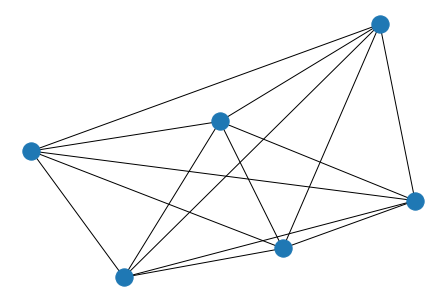

In [161]:
nx.draw(newG)

Clusters of graphs connect them

Tree and then add edges

Purely Random